# System Logs Anomaly Detection using Fine-Tuned LLMs

A fine-tuned LLMs to classify logs as 'normal' or 'anomalous'.

---

## Setup and Imports

In [26]:
!pip install torch transformers datasets scikit-learn pandas numpy tqdm seaborn matplotlib nlpaug sentencepiece

Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


In [27]:
import os
import re
import torch
import pandas as pd
import random as rd
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.utils import resample
import nlpaug.augmenter.word as naw
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments

---

## Data Loading & Preprocessing

#### 1. Load log data

In [28]:
# Ignore warning
pd.set_option('future.no_silent_downcasting', True)

logs_df = pd.read_csv("./data/logs.csv")
labels_df = pd.read_csv("./data/labels.csv")

print(f"Log entries: {len(logs_df)}")

Log entries: 104815


In [29]:
logs_df.head(1)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>


In [30]:
labels_df.head(1)

,BlockId,Label
0,blk_-1608999687919862906,Normal


---

#### 2. Merge logs & labels datasets

In [31]:
# Extract blockId from content for merging
logs_df["BlockId"] = logs_df["Content"].str.extract(r'(blk_-?\d+)')
# Merge dataset into one
logs_df = pd.merge(logs_df, labels_df, on="BlockId")
# Map 'Normal' to '1' & 'Anomaly' to '0'
logs_df["Label"] = logs_df["Label"].replace({'Normal': 0, 'Anomaly': 1})

In [32]:
logs_df.head(1)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,BlockId,Label
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906,0


#### 3. Normalisation

In [33]:
# Different possible dynamic fields in a log entry
patterns = [
    r'True',
    r'true',
    r'False',
    r'false',
    r'\b(zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion)\b',
    r'\b(Mon|Monday|Tue|Tuesday|Wed|Wednesday|Thu|Thursday|Fri|Friday|Sat|Saturday|Sun|Sunday)\b',
    r'\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+(\d{1,2})\s+\b',
    r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}(:\d{1,5})?',
    r'([0-9A-Fa-f]{2}:){11}[0-9A-Fa-f]{2}',
    r'([0-9A-Fa-f]{2}:){5}[0-9A-Fa-f]{2}',
    r'[a-zA-Z0-9]*[:\.]*([/\\]+[^/\\\s\[\]]+)+[/\\]*',
    r'\b[0-9a-fA-F]{8}\b',
    r'\b[0-9a-fA-F]{10}\b',
    r'(\w+[\w\.]*)@(\w+[\w\.]*)\-(\w+[\w\.]*)',
    r'(\w+[\w\.]*)@(\w+[\w\.]*)',
    r'[a-zA-Z\.\:\-\_]*\d[a-zA-Z0-9\.\:\-\_]*',
]
combined_pattern = '|'.join(patterns)

# helper function to replace dynamic fields with <*>
def replace_dynamic_fields(log):
    log = re.sub(r'[\.]{3,}', '.. ', log)
    log = re.sub(combined_pattern, '<*>', log)
    return log

In [34]:
# Replace dynamic fileds
logs_df['processed_content'] = logs_df['Content'].apply(replace_dynamic_fields)
# Rename column name
logs_df = logs_df.rename(columns={'Label': 'label'})
# Only needed
logs_df = logs_df[['processed_content', 'label']]

In [35]:
logs_df.head()

,processed_content,label
0,Receiving block <*> src: <*> dest: <*>,0
1,BLOCK* NameSystem.allocateBlock: <*> <*>,0
2,Receiving block <*> src: <*> dest: <*>,0
3,Receiving block <*> src: <*> dest: <*>,0
4,PacketResponder <*> for block <*> terminating,0


#### 4. Data Distribution (before 'balancing')


label
0    101544
1      3271
Name: count, dtype: int64



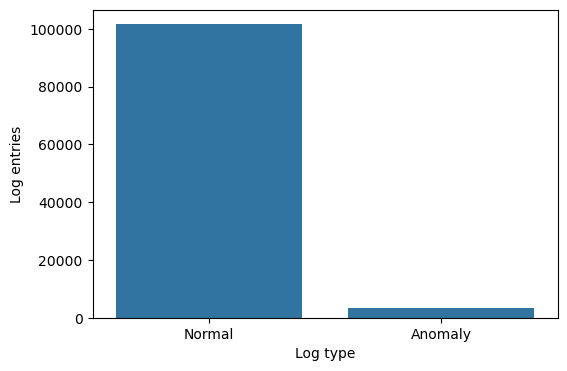


Anomaly: 3.12%



In [36]:
# utility function to calculate the data distribution
def plot_data_distribution(df):
    # Count the labels
    labels_count = df['label'].value_counts()
    print(f"\n{labels_count}\n")
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=labels_count.index, y=labels_count.values)
    plt.xticks([0, 1], ['Normal', 'Anomaly'])
    plt.ylabel("Log entries")
    plt.xlabel("Log type")
    plt.show()
    
    anomaly = labels_count[1] / sum(labels_count) * 100
    print(f"\nAnomaly: {anomaly:.2f}%\n")

plot_data_distribution(logs_df)

Here, the data is highly imbalanced

#### 5. Balance Dataset

In [37]:
# split the datasets
normal_df = logs_df[logs_df['label'] == 0]
anomaly_df = logs_df[logs_df['label'] == 1]

In [38]:
# utilty function to augment anomalies by swapping or deleting words 
def augment_anomalies(log, max_changes=1):
    aug = rd.choice([
        naw.RandomWordAug(action="swap"), 
        naw.RandomWordAug(action="delete")
    ])
    augmented = aug.augment(log, n=max_changes)
    return augmented[0] if isinstance(augmented, list) else augmented

# augment
new_anomaly_df = anomaly_df.copy()
new_anomaly_df['processed_content'] = new_anomaly_df['processed_content'].apply(lambda txt: augment_anomalies(txt, 2))

# combine both original & new anomalies
combined_anomaly_df = pd.concat([anomaly_df, new_anomaly_df])

# resample the new anomalies to match normal log entries
balanced_df = resample(combined_anomaly_df, replace=True, n_samples=len(normal_df), random_state=42)

# balanced dataset
new_log_df = pd.concat([normal_df, balanced_df])
new_log_df = new_log_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [39]:
new_log_df.head(5)

,processed_content,label
0,Receiving block <*> src: <*> dest: <*>,0
1,Receiving block <*> src: <*> dest: <*>,0
2,Block <*> <*> <* >,1
3,BLOCK* NameSystem.addStoredBlock: blockMap upd...,1
4,Received block <*> of size <*> from <*>,0


#### 6. Data Distribution (after 'balancing')


label
0    101544
1    101544
Name: count, dtype: int64



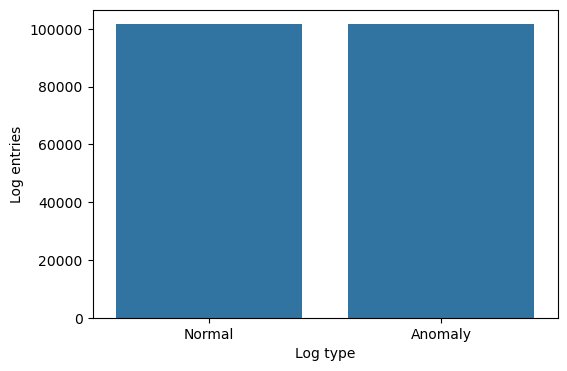


Anomaly: 50.00%



In [40]:
plot_data_distribution(new_log_df)

#### 7. Split dataset: Training & Test

In [41]:
train_df, test_df = train_test_split(
    new_log_df,
    test_size=0.2,
    random_state=42,
    stratify=new_log_df["label"]
)

print(f"Training Split: {len(train_df)} | Test Split: {len(test_df)}")

Training Split: 162470 | Test Split: 40618


---

## Model Training
*Using Lightweight models for training convenience. Will change it in the later stage of project*

## Model Training

#### 1. Initialise the model
We are using 'deberta-v3-large' model 

In [42]:
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")
model = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-large",
    num_labels=2,
    problem_type="single_label_classification"
).to('cuda')

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


AssertionError: Torch not compiled with CUDA enabled

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

#### 2. Prepare custom dataset
For creating tokens of log entries for taining transformer models

In [ ]:
class LogDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            max_length=max_length,
            padding="max_length"
        )
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]).to('cuda'),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]).to('cuda'),
            'labels': torch.tensor(self.labels[idx]).to('cuda')
        }

#### 3. Split dataset: Training & Test

In [ ]:
train_df, test_df = train_test_split(new_log_df, test_size=0.2)
training_dataset = LogDataset(train_df['processed_content'], train_df['label'], tokenizer)
testing_dataset = LogDataset(test_df['processed_content'], test_df['label'], tokenizer)

print(f"Training Split: {len(training_dataset)} | Test Split: {len(testing_dataset)}")

#### 4. Train the model

In [ ]:
# Define training arguments
training_arguments = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    num_train_epochs=4,
    evaluation_strategy="steps",
    eval_steps=200,
    logging_dir="./logs",
    fp16=True,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Train model
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=training_dataset,
    eval_dataset=testing_dataset,
)
trainer.train()

#### 5. Save the model

In [ ]:
trainer.save_model("./log_anomaly_model")
tokenizer.save_pretrained("./log_anomaly_model")

---

## Model Evaluation